In [160]:
### keep the imports
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize


In [168]:
# pre process and normalize
# no missing data :)!!
df = pd.read_csv("data.csv.data")
df = df[["ACD", "AL", "WTW", "K1", "K2", "Correto"]]

df["ACD"] = df["ACD"].apply(lambda x: x.replace(",", '.')).apply(float)
df["AL"] = df["AL"].apply(lambda x: x.replace(",", '.')).apply(float)
df["WTW"] = df["WTW"].apply(lambda x: x.replace(",", '.')).apply(float)
df["K1"] = df["K1"].apply(lambda x: x.replace(",", '.')).apply(float)
df["K2"] = df["K2"].apply(lambda x: x.replace(",", '.')).apply(float)
df["Correto"] = df["Correto"].apply(lambda x: 1 if x == 'S'  else 0)


columns = ["ACD", "AL", "WTW", "K1", "K2"]
df[columns] = (df[columns]-df[columns].min())/(df[columns].max()-df[columns].min())
# normalize(df[columns])
df.head()
# df.describe()

,ACD,AL,WTW,K1,K2,Correto
0,0.534146,0.336725,0.617647,0.685606,0.560130,1
1,0.551220,0.411656,0.705882,0.600649,0.541712,1
2,0.580488,0.410731,0.705882,0.643939,0.492958,1
3,0.446341,0.359852,0.617647,0.617965,0.481040,1
4,0.319512,0.430157,0.676471,0.545455,0.418202,1


<Axes: ylabel='Frequency'>

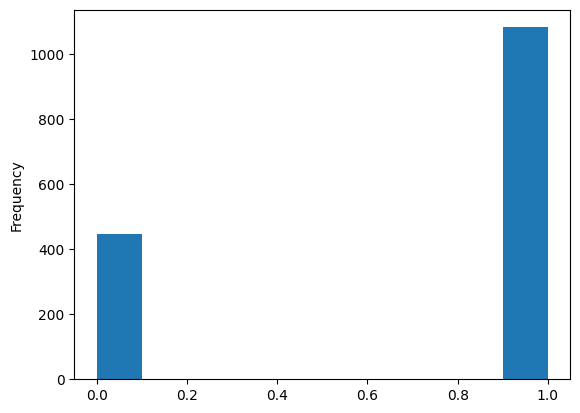

In [162]:
#Just check balance and relation
df['Correto'].plot(kind="hist")
# columns = ["AL", "ACD", "WTW", "K1", "K2"]

# for c1 in columns:
#     for c2 in columns:
#         if c1 != c2:
#             df.plot.scatter(x=c1, y=c2, c=df["Correto"].apply(lambda x: "green" if x else "red"))

# Great part of the outliers are 0, witch the database already have a small sample.

In [163]:
##get strat samples
groups = df.groupby("Correto")
g0 = groups.get_group(0).sample(frac=1, replace=False)
g1 = groups.get_group(1).sample(frac=1, replace=False)
samples = []

for i in range(5):
    samples.append(pd.concat([g0[i*(len(g0)//5):(i+1)*(len(g0)//5)], g1[i*(len(g1)//5):(i+1)*(len(g1)//5)]]))

samples, final_test = samples[:4], samples[4]



In [164]:
def cross_validate(samples, model):
    results = []
    for i in range(len(samples)):

        test = samples.pop(0)
        train = pd.concat(samples)

        model.fit(train[columns], train["Correto"])

        predict = model.predict(test[columns])

        results.append(roc_auc_score(test["Correto"], predict))
        samples.append(test)
    return results


In [165]:
#kNN tests

results = []
n_neighbors = 5
model = KNeighborsClassifier(n_neighbors=n_neighbors)
results = cross_validate(samples, model)

print(results)
#  ["ACD", "AL", "WTW", "K1", "K2"]
predict = model.predict(final_test[columns])
print(roc_auc_score(final_test["Correto"], predict))
tn, fp, fn, tp = confusion_matrix(final_test["Correto"], predict).ravel()
# Increasse n_neighbors incriases tp and reduces fp and tn.
print( tp, fp)
print( fn, tn)



[0.5068924261339992, 0.5145131086142323, 0.5254109446525177, 0.5382854764877237]
0.5382854764877237
184 69
32 20


In [166]:
#ID3 test
results = []
model = RandomForestClassifier()
results = cross_validate(samples, model)

print(results)

predict = model.predict(final_test[columns])
print(roc_auc_score(final_test["Correto"], predict))
tn, fp, fn, tp = confusion_matrix(final_test["Correto"], predict).ravel()

print( tp, fp)
print( fn, tn)



[0.4939918851435705, 0.5290522263836871, 0.5478828547648773, 0.5796140241364961]
0.5382854764877237
184 69
32 20


In [167]:
#ID3 test
results = []
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10),
                    random_state=1, max_iter=20000, activation="relu")
results = cross_validate(samples, model)

print(results)

predict = model.predict(final_test[columns])
print(roc_auc_score(final_test["Correto"], predict))
tn, fp, fn, tp = confusion_matrix(final_test["Correto"], predict).ravel()

print( tp, fp)
print( fn, tn)



[0.5175041614648356, 0.5469205160216396, 0.5132126508531003, 0.5079067831876821]
0.5274136496046609
206 80
10 9
